In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive
%cd MyDrive
%cd 'Data Science Group Project - Big Data Course'

c1 = pd.read_csv('completed_matches.csv').drop('Unnamed: 0', axis=1).convert_dtypes() # completed_matches
u1 = pd.read_csv('upcoming_matches.csv').drop('Unnamed: 0', axis=1).convert_dtypes() # upcoming matches
p1 = pd.read_csv('players.csv').drop('Unnamed: 0', axis=1).convert_dtypes() # players

print(c1.shape)
print(p1.shape)
print(u1.shape)

c = c1.copy()
u = u1.copy()
p = p1.copy()


Mounted at /content/drive
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/Data Science Group Project - Big Data Course
(6891, 78)
(2334, 22)
(60, 24)


In [4]:
c.columns

Index(['player_1_name', 'player_2_name', 'weight_class', 'win', 'duration',
       'kd', 'o_kd', 'ss_hit', 'ss_att', 'o_ss_hit', 'o_ss_att', 'ss_perc',
       'o_ss_perc', 's_hit', 's_att', 'o_s_att', 'o_s_hit', 'td_hit', 'td_att',
       'o_td_hit', 'o_td_att', 'td_perc', 'o_td_perc', 'sub_att', 'o_sub_att',
       'rev', 'o_rev', 'ctrl', 'o_ctrl', 'ss_head_hit', 'ss_head_att',
       'o_ss_head_hit', 'o_ss_head_att', 'ss_body_hit', 'ss_body_att',
       'o_ss_body_hit', 'o_ss_body_att', 'ss_leg_hit', 'ss_leg_att',
       'o_ss_leg_hit', 'o_ss_leg_att', 'ss_dist_hit', 'ss_dist_att',
       'o_ss_dist_hit', 'o_ss_dist_att', 'ss_clinch_hit', 'ss_clinch_att',
       'o_ss_clinch_hit', 'o_ss_clinch_att', 'ss_ground_hit', 'ss_ground_att',
       'o_ss_ground_hit', 'o_ss_ground_att', 'player_1_url', 'player_2_url',
       'match_url', 'event_date', 'event_month', 'event_year', 'wins_diff',
       'losses_diff', 'ties_diff', 'nc_diff', 'total_matches_diff',
       'height_diff', 'weight_diff

In [5]:
def clean_c(df):

  print('Data cleaning. Starting shape:', df.shape)

  # Counting nan values in all fields
  print('Fill NAs with median of dimension')
  print([(x, y) for x, y in zip(df.isna().sum(), df.isna().sum().index) if x > 0])
  # Fill NAs with the median value of each column
  median_values = df.select_dtypes(include=['int64', 'float64']).median()
  df = df.fillna(median_values)
  print(df.shape)

  print('Remove events befor 2013 for relevance')
  df = df.loc[(df.event_year >= 2013)]

  return df


In [6]:
df = clean_c(c)

Data cleaning. Starting shape: (6891, 78)
Fill NAs with median of dimension
[(12, 'height_diff'), (9, 'weight_diff'), (1035, 'reach_diff'), (195, 'age_diff')]
(6891, 78)
Remove events befor 2013 for relevance


In [7]:
# Group the dataframe by the boolean column
grouped = c.groupby('win')

# Define the sample size for each group
sample_size = 500

# Initialize an empty dataframe to store the samples
samples = pd.DataFrame()

# Loop over each group
for group_name, group_data in grouped:
    # If the group has enough rows, sample the required number of rows
    if len(group_data) >= sample_size:
        group_sample = group_data.sample(sample_size)
    # If the group has fewer rows than the required sample size, sample all rows
    else:
        group_sample = group_data.sample(len(group_data))
    # Append the group sample to the overall samples dataframe
    samples = samples.append(group_sample)

# Reset the index of the samples dataframe
samples = samples.reset_index(drop=True)
print(samples.shape)
samples.head()

(1000, 78)


<ipython-input-7-6cad7b3c41bd>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  samples = samples.append(group_sample)
<ipython-input-7-6cad7b3c41bd>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  samples = samples.append(group_sample)


,player_1_name,player_2_name,weight_class,win,duration,kd,o_kd,ss_hit,ss_att,o_ss_hit,...,age_diff,ss_diff,ss_acc_diff,ss_abs_diff,ss_def_diff,td_diff,td_acc_diff,td_def_diff,sub_diff,prev_diff
0,Takeya Mizugaki,Aljamain Sterling,Bantamweight,0,15,0,0,13,42,32,...,6,-1.33,-0.14,1.09,-0.04,-0.52,0.33,0.29,-0.8,-2
1,Nathaniel Wood,Casey Kenney,Featherweight,0,15,0,0,136,321,123,...,-2,1.49,0.06,-0.25,-0.01,0.72,0.19,0.12,0.2,1
2,Jussier Formiga,Brandon Moreno,Flyweight,0,15,0,0,15,32,33,...,-8,2.16,0.0,0.99,-0.07,-0.11,0.09,-0.19,0.0,2
3,Dennis Bermudez,Chan Sung Jung,Lightweight,0,25,0,1,20,34,17,...,1,0.45,0.04,-1.28,0.07,3.15,-0.07,0.1,0.4,0
4,Darren Stewart,Francimar Barroso,Light Heavyweight,0,15,0,0,31,73,28,...,10,-0.28,0.07,-0.22,0.11,0.47,-0.21,0.16,-0.1,1


In [8]:
# Select the top 100 players with the best win/loss records and look at a the hist pairplot

p_plot = p.copy()

# Create a win ratio
p_plot['win_ratio'] = round(p_plot['wins'] / p_plot['losses'], 2)
p_plot['win_ratio'] = p_plot['win_ratio'].replace([np.inf, -np.inf], np.nan)
p_plot = p_plot.dropna()

# Create other features
p_plot['aggr'] = p_plot['ss_def'] / p_plot['ss'] # Aggression: small number means better aggression

# Isolate only to players with many matches and in lighter classes
p_plot = p_plot.loc[(p_plot.total_matches >= 20)
                    & (p_plot.weight_class.isin(['Flyweight', 'Lightweight', 'Bantamweight']))
]

# After the cutoff is determined, collect the top 100 that meet the cutoff
# p_plot = p_plot.sort_values('win_ratio', ascending=False).head(100)

# Select the dimensions of interest
p_plot = p_plot[['height', 'weight', 'reach', 'age', 'ss', 'ss_acc', 'ss_abs', 'wins', 'losses',
                 'ss_def', 'aggr', 'td', 'td_acc', 'td_def', 'sub', 'prev', 'win_ratio']]
p_plot = p_plot.astype('float')

# Next, plot the hist pairplot and inspect.

# sns.pairplot(p_plot, kind="hist")
# plt.legend(loc='upper center', bbox_to_anchor=(1.10, 1.0), ncol=1) # vertical legend

# plt.show()

# p_plot.info()

<ipython-input-15-f40348541240>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_plot_1['win_ratio_binned'] = pd.qcut(p_plot_1['win_ratio'], q=[0, 0.33, 0.67, 1], labels=['Low', 'Medium', 'High'])


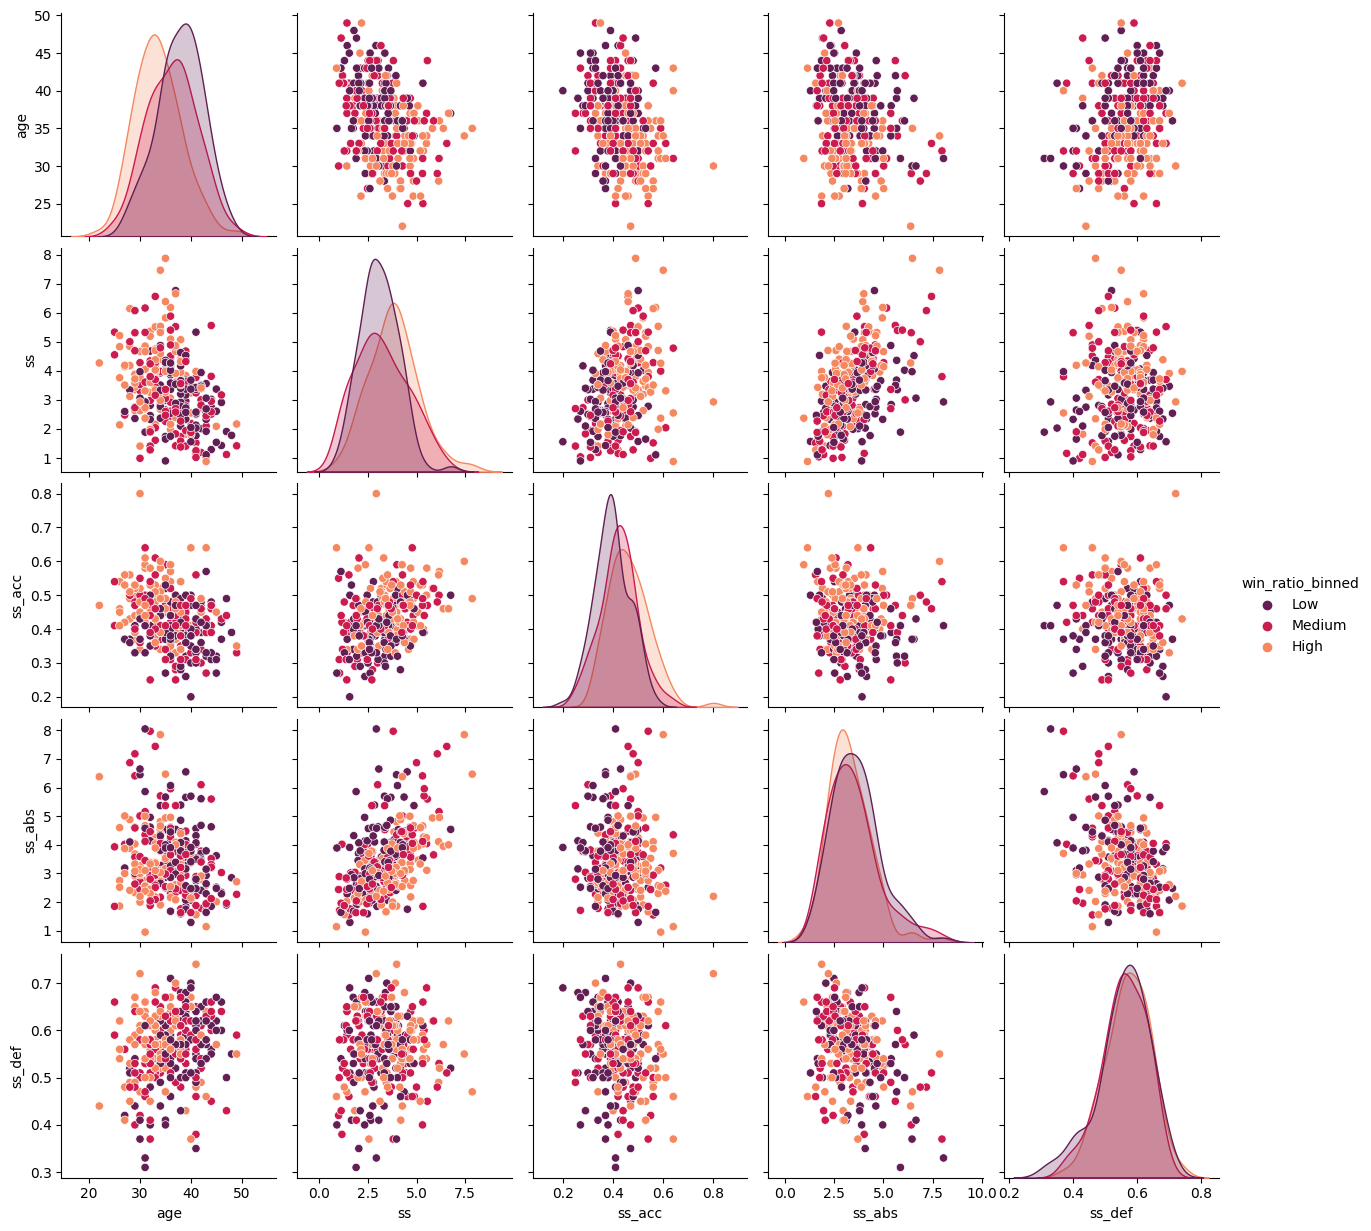

In [15]:
p_plot_1 = p_plot[['win_ratio', 'age', 'ss', 'ss_acc', 'ss_abs', 'ss_def']]

# p_plot_1['win_ratio_binned'] = pd.cut(p_plot_1['win_ratio'], bins=3)
p_plot_1['win_ratio_binned'] = pd.qcut(p_plot_1['win_ratio'], q=[0, 0.33, 0.67, 1], labels=['Low', 'Medium', 'High'])


p_plot_1 = p_plot_1.drop(columns=['win_ratio'])

# Remove outliers: The following constraints were selected after visualizing the data first for outliers
p_plot_1 = p_plot_1.loc[(p_plot_1.ss_abs < 20)]

# Next, plot the hist pairplot and inspect.

g = sns.pairplot(p_plot_1, kind="scatter", hue= 'win_ratio_binned', palette='rocket')
# plt.legend(loc='upper center', bbox_to_anchor=(1.10, 1.0), ncol=1) # vertical legend
# g.map_lower(sns.kdeplot, levels=3)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


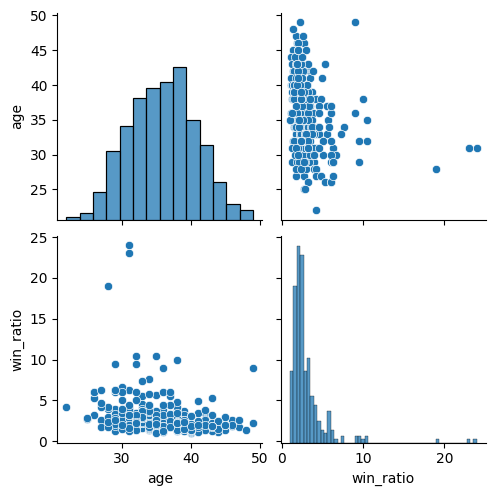

In [34]:
p_plot_age_wr = p_plot[['age', 'win_ratio']]

g = sns.pairplot(p_plot[['age', 'win_ratio']], kind="scatter", palette='rocket')

plt.show()

Wins and reach seem correlated

<Axes: >

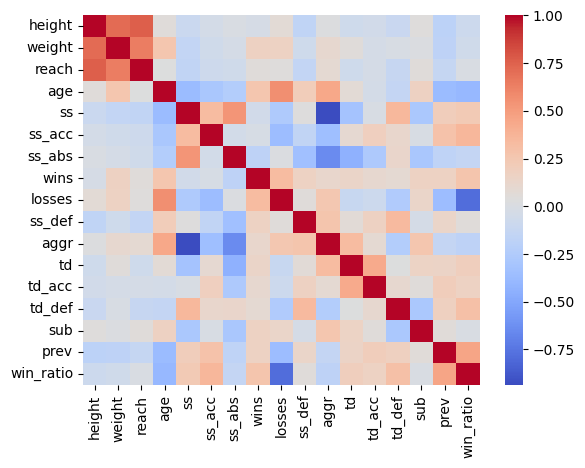

In [31]:
# Plot heatmap

# c.loc[:, c.select_dtypes(['float64', 'int64']).columns]

corr_matrix = p_plot.corr(method='spearman')

sns.heatmap(corr_matrix, cmap='coolwarm')

Takedowns and takedown defence have the strongest correlation with win ratio.

Age is correlated with both wins and losses. Aggression and age seem to be positively correlated.

Takedown defence and ss defence are correlated.

Submissions are correlated with wins.

Aggression and age seem to be positively correlated.

In [12]:
# Take a smaller sample of the players dataset and pairplot the hue = win to see how wins and losses correlate to feature combinations

# Drop few nulls: There are a few null values in the reach column because reach has many nulls in the players dataset.
p1 = p.dropna()
print(p1.shape[0], 'non-null players out of', p.shape[0])

p1 = p1.drop(['player_url', 'player_name', 'weight_class'], axis=1)

# Based on number of fights
p1 = p1.loc[p['total_matches'] >= 5] # inexperienced, after 5 they're more stable in their playing style
p1 = p1.loc[p['total_matches'] <= 100] # outlier

print('Number of players with >=5 matches and <= 200 matches')
print(p1.shape[0], p.shape[0])

# Weight outlier
p1 = p1.loc[p1.weight <= 500]

p1['win_ratio'] = round(p1['wins'] / p1['losses'], 2)
drop_infs = p1.loc[np.isinf(p1).values].index
p1 = p1.drop(drop_infs)

# Draw a sample
sample_size = 1000
p1 = p.sample(sample_size)

# Pairplot
sns.pairplot(p1)
plt.legend(loc='upper center', bbox_to_anchor=(1.10, 1.0), ncol=1) # vertical legend


Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Joint Grid?
# https://seaborn.pydata.org/generated/seaborn.JointGrid.html#seaborn.JointGrid